Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [2]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive')

# When run locally via Jupyter, change dir to 'data/'
dir = '/content/drive/MyDrive/ML_Fall2025_Supernovae/updated_data/'

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#adjust font sizes for visibility on slides
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
})

# Step 1: Data Analysis

## First, we load datasets of both models.

In [5]:
# Model 1:
I_Ia = pd.read_csv(dir + 'model1_TypeIa_updated.csv').dropna()
I_Ibc = pd.read_csv(dir + 'model1_TypeIbc_updated.csv').dropna()
I_II = pd.read_csv(dir + 'model1_TypeII_updated.csv').dropna()
I_IIn = pd.read_csv(dir + 'model1_TypeIIn_updated.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II', 'IIn']

In [6]:
# Model 2:
II_Ia = pd.read_csv(dir + 'model2_TypeIa_updated.csv').dropna()
II_Ibc = pd.read_csv(dir + 'model2_TypeIbc_updated.csv').dropna()
II_II = pd.read_csv(dir + 'model2_TypeII_updated.csv').dropna()
II_IIn = pd.read_csv(dir + 'model2_TypeIIn_updated.csv').dropna()
II_skip = ['sn_name', 'sn_type', 'band']
II_labels = ['Ia', 'Ibc', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [7]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip] #dfs[0].columns[2:] to show bands

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

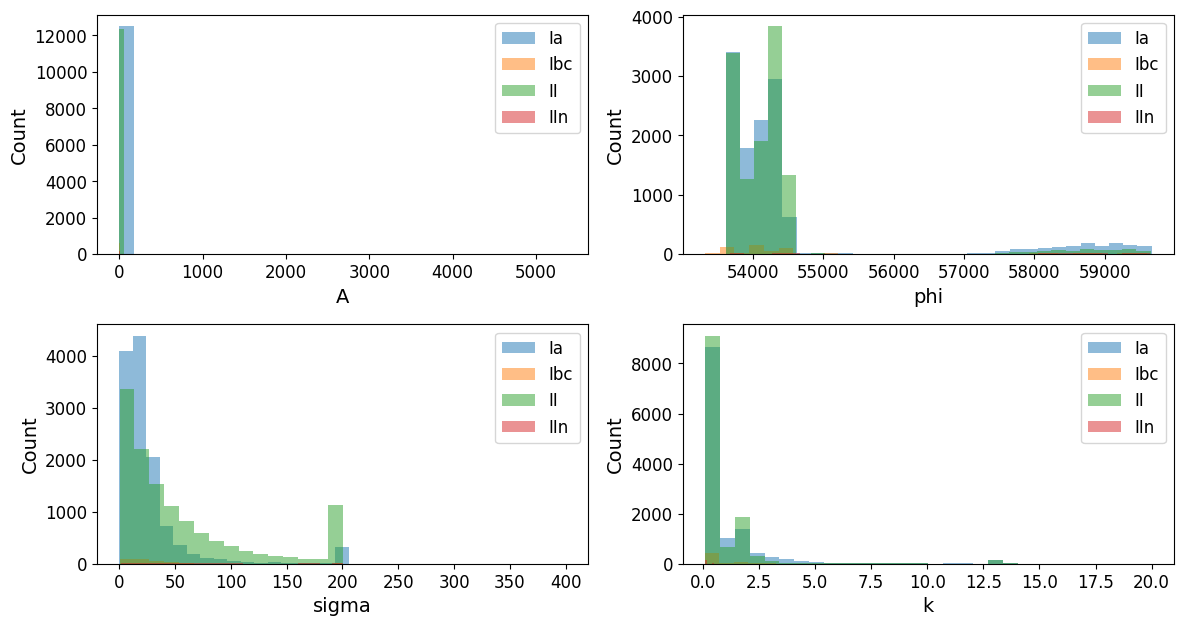

In [8]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II, I_IIn], I_skip, I_labels)

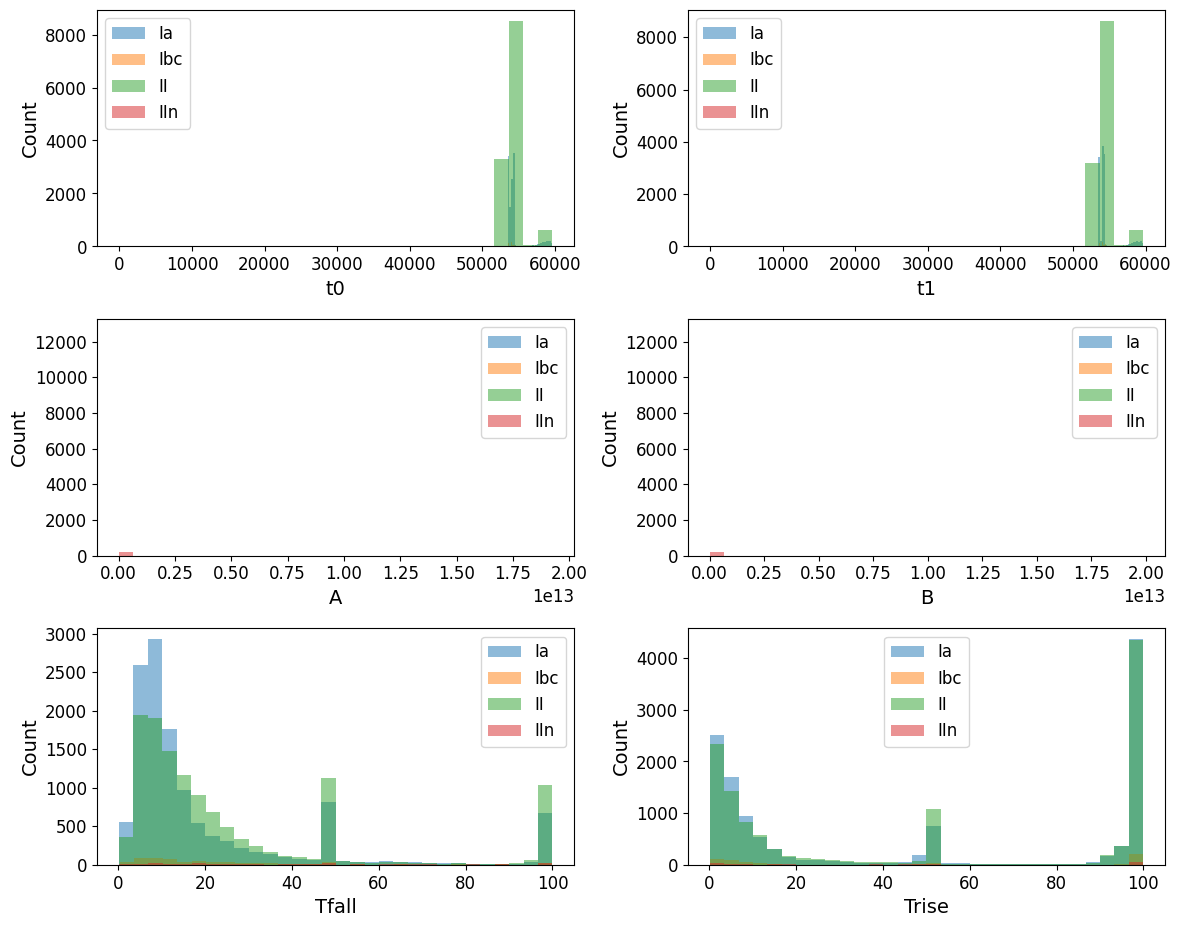

In [9]:
# Histograms for Model 2
histogram_all([II_Ia,II_Ibc,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [10]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = dfs[0].columns[3:]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

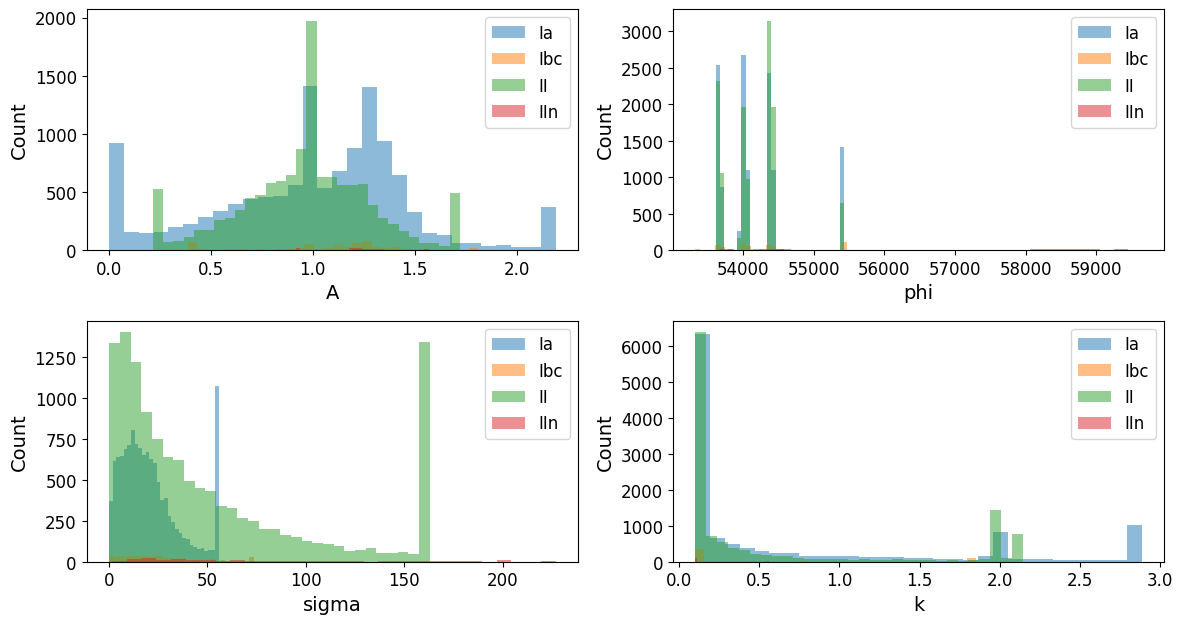

In [11]:
I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip = clipping([I_Ia,I_Ibc,I_II, I_IIn], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], I_skip, I_labels)

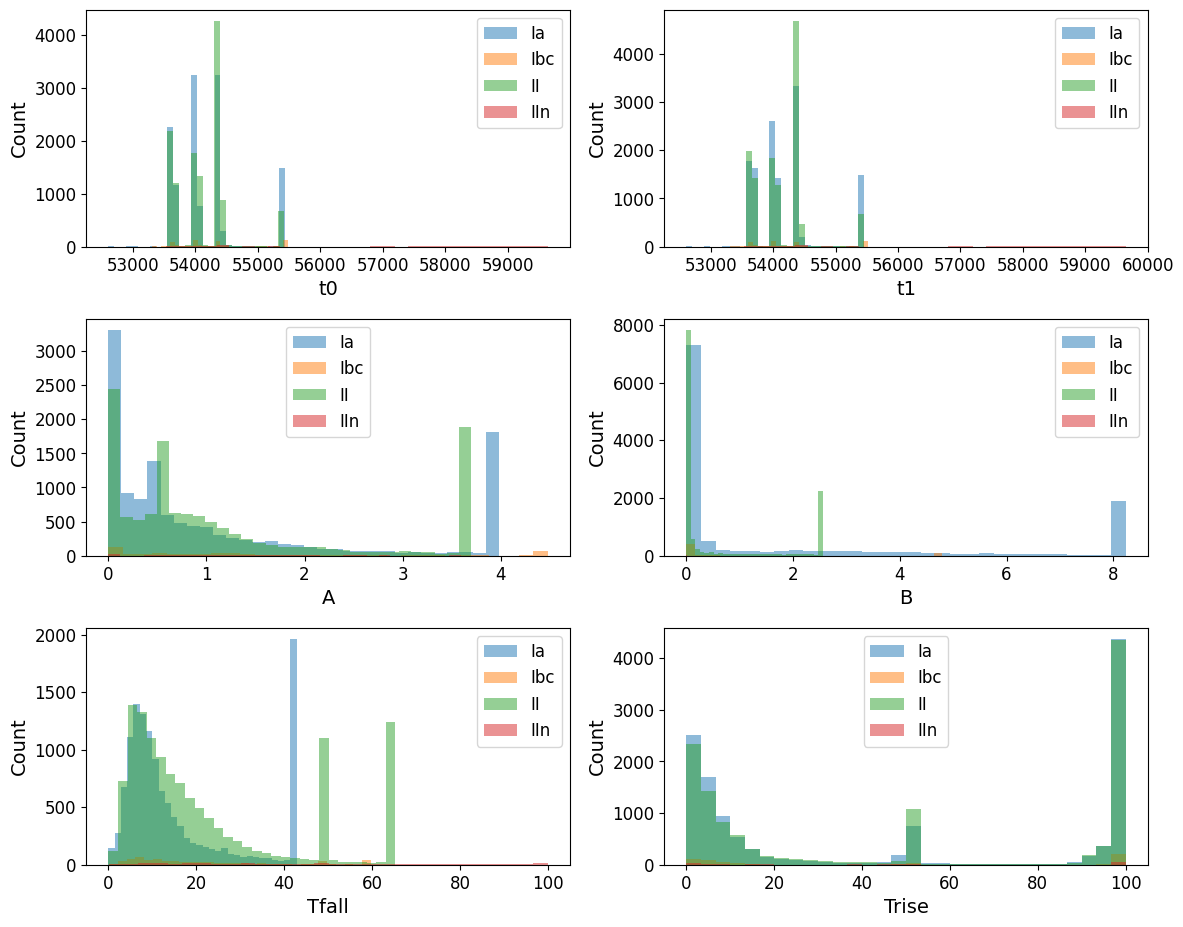

In [12]:
II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_Ibc,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)

# Step 2: Prepare for training

In [13]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

## First, we define a function for evaluating performance of a model.

In [22]:
def evaluate_model(model, X_train, y_train, X_test, y_test, band_test, class_names=None, history=None):
  # -----------------------
  # Training set evaluation
  # -----------------------
  print("Training set:")
  if history is not None:  # Keras
    y_train_proba = model.predict(X_train)
    y_train_pred = np.argmax(y_train_proba, axis=1)
  else:
    if hasattr(model, "predict_proba"):
      y_train_proba = model.predict_proba(X_train)
      y_train_pred = np.argmax(y_train_proba, axis=1)
    else:
      y_train_pred = model.predict(X_train)  # labels only
      y_train_proba = label_binarize(y_train_pred, classes=np.unique(y_train))

  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("\nClassification report:\n", classification_report(y_train, y_train_pred))
  print("\nConfusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  # -----------------------
  # Test set evaluation
  # -----------------------
  print("\nTest set:")
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)

  # Predict probabilities
  if history is not None:
    y_score = model.predict(X_test)
  else:
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)

    elif hasattr(model, "decision_function"):
      dec = model.decision_function(X_test)

      # Ensure 2D
      if dec.ndim == 1:
        dec = np.vstack([-dec, dec]).T

      # Convert decision scores: pseudo-probabilities
      y_score = softmax(dec, axis=1)

    else:
      # completely fallback: use predicted labels as 0/1
      labels = model.predict(X_test)
      y_score = label_binarize(labels, classes=classes)

  # Ensure correct shape
  y_score = np.array(y_score)
  if y_score.shape[1] != n_classes:
    y_score = y_score[:, :n_classes]

  # Compute ROC thresholds
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  roc_thresholds = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Youden's J statistic
    J = tpr[i] - fpr[i]
    ix = np.argmax(J)
    roc_thresholds[i] = thresholds[ix]

  # Predict labels using ROC thresholds
  y_test_pred = np.full(X_test.shape[0], -1, dtype=int)  # -1 = uncertain (optional)

  not_classified = 0
  for j in range(X_test.shape[0]):
    above_thresh = [i for i in range(n_classes) if y_score[j, i] >= roc_thresholds[i]]
    if above_thresh:
      # choose class with highest probability among those exceeding threshold
      y_test_pred[j] = above_thresh[np.argmax([y_score[j, i] for i in above_thresh])]
    else:
      # fallback to most probable class
      # y_test_pred[j] = np.argmax(y_score[j, :])
      not_classified += 1

  print("\nNot classified:", not_classified)

  mask = y_test_pred != -1
  print("Accuracy:", accuracy_score(y_test[mask], y_test_pred[mask]))
  print("\nClassification report:\n", classification_report(y_test[mask], y_test_pred[mask]))
  print("\nConfusion matrix:\n", confusion_matrix(y_test[mask], y_test_pred[mask]))

  # -----------------------
  # Plot the ROC curves
  # -----------------------
  plt.figure(figsize=(7,6))

  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], lw=2, #color=colors(i),
             label=f'{label} (AUC = {roc_auc[i]:.2f})')#, Threshold = {roc_thresholds[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

  # ----------------------------------------------
  # Plot XGBClassifier train/val loss if available
  # ----------------------------------------------
  if hasattr(model, "evals_result"):
    try:
      results = model.evals_result()
    except:
      results = model.get_booster().evals_result()

    # print("\nEvals result keys:", results.keys())  # debug

    # mlogloss is your eval_metric
    train_key = list(results.keys())[0]
    val_key  = list(results.keys())[1]

    metric_name = list(results[train_key].keys())[0]

    train_loss = results[train_key][metric_name]
    val_loss   = results[val_key][metric_name]

    plt.figure(figsize=(7,6))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Boosting Rounds")
    plt.ylabel('Loss')
    plt.title("XGBoost Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  # ----------------------------------------------
  # Plot MLPClassifier train/val loss if available
  # ----------------------------------------------
  if history is not None:
    plt.figure(figsize=(7,6))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  if band_test is not None:
      print("\n==============================")
      print(" Per-band evaluation:")
      print("==============================")

      bands = sorted(band_test.unique())
      y_test_pred_all = model.predict(X_test)
      if history is not None:
          y_test_pred_all = np.argmax(y_test_pred_all, axis=1)

      for b in bands:
          idx = (band_test == b)
          y_true_b = y_test[idx]
          y_pred_b = y_test_pred_all[idx]

          print(f"\n--- Band = {b} ---")
          print("Count:", len(y_true_b))
          if len(y_true_b) == 0:
              print("No samples in this band.")
              continue

          print("Accuracy:", accuracy_score(y_true_b, y_pred_b))
          print(classification_report(y_true_b, y_pred_b))
          print("Confusion matrix:\n", confusion_matrix(y_true_b, y_pred_b))


## Second, we prepare features and labels.

In [15]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]
I_band = I['band']

# Extracting labels
I_y = I['sn_type']
#print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II, and 3 for IIn
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp, I_X_test, I_y_temp, I_y_test, I_band_temp, I_band_test = train_test_split(
    I_X, I_y, I_band,
    test_size=0.1,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_X_train, I_X_val, I_y_train, I_y_val, I_band_train, I_band_val = train_test_split(
    I_X_temp, I_y_temp, I_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_val = I_scaler.fit_transform(I_X_val)
I_X_test = I_scaler.transform(I_X_test)

# Compute weights
I_classes = np.unique(I_y_train)
I_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train
)
I_class_weights = dict(zip(I_classes, I_class_weights))
I_sample_weights = np.array([I_class_weights[label] for label in I_y_train])

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Validation:\n",pd.Series(I_y_val).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

Total:
 sn_type
0    12528
2    12396
1      596
3      181
Name: count, dtype: int64
Train:
 sn_type
0    8769
2    8677
1     417
3     127
Name: count, dtype: int64
Validation:
 sn_type
0    2506
2    2479
1     119
3      36
Name: count, dtype: int64
Test:
 sn_type
0    1253
2    1240
1      60
3      18
Name: count, dtype: int64


In [28]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]
II_band = II['band']

# Extracting labels
II_y = II['sn_type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II and 3 for IIn
II_name_Ia = ['Ia','IaQ','Ia_Pec']
II_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
II_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
II_y = II_y.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Encode categorical labels
#II_y = II_y.map({'Ia': 0, 'II': 1, 'IIn': 2})

# Split data and scale
II_X_temp, II_X_test, II_y_temp, II_y_test, II_band_temp, II_band_test = train_test_split(
    II_X, II_y, II_band,
    test_size=0.1,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_X_train, II_X_val, II_y_train, II_y_val, II_band_train, II_band_val = train_test_split(
    II_X_temp, II_y_temp, II_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_val = II_scaler.fit_transform(II_X_val)
II_X_test = II_scaler.transform(II_X_test)

# Compute weights
II_classes = np.unique(II_y_train)
II_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train
)
II_class_weights = dict(zip(II_classes, II_class_weights))
II_sample_weights = np.array([II_class_weights[label] for label in II_y_train])
print(II_sample_weights)
# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Validation:\n",pd.Series(II_y_val).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

[0.51277414 0.51923077 0.51277414 ... 0.51923077 0.51277414 0.51277414]
Total:
 sn_type
0    12637
2    12481
1      604
3      199
Name: count, dtype: int64
Train:
 sn_type
0    8846
2    8736
1     423
3     139
Name: count, dtype: int64
Validation:
 sn_type
0    2527
2    2496
1     121
3      40
Name: count, dtype: int64
Test:
 sn_type
0    1264
2    1249
1      60
3      20
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [17]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000), I_IIn_clip], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]
I_band_down = I_down['band']

# Extracting labels
I_y_down = I_down['sn_type']
#print("Unique mapped labels:", I_y_down.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp_down, I_X_test_down, I_y_temp_down, I_y_test_down, I_band_temp_down, I_band_test_down = train_test_split(
    I_X_down, I_y_down, I_band_down,
    test_size=0.1,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_X_train_down, I_X_val_down, I_y_train_down, I_y_val_down, I_band_train_down, I_band_val_down = train_test_split(
    I_X_temp_down, I_y_temp_down, I_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_val_down = I_scaler_down.fit_transform(I_X_val_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Compute weights
I_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train_down
)
I_class_weights_down = dict(zip(I_classes, I_class_weights_down))
I_sample_weights_down = np.array([I_class_weights_down[label] for label in I_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Validation:\n",pd.Series(I_y_val_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     596
3     181
Name: count, dtype: int64
Train:
 sn_type
2    700
0    700
1    417
3    126
Name: count, dtype: int64
Validation:
 sn_type
0    200
2    200
1    119
3     37
Name: count, dtype: int64
Test:
 sn_type
0    100
2    100
1     60
3     18
Name: count, dtype: int64


In [18]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(2000), II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]
II_band_down = II_down['band']

# Extracting labels
II_y_down = II_down['sn_type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y_down = II_y_down.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data into 70/20/10 and scale
II_X_temp_down, II_X_test_down, II_y_temp_down, II_y_test_down, II_band_temp_down, II_band_test_down = train_test_split(
    II_X_down, II_y_down, II_band_down,
    test_size=0.1,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_X_train_down, II_X_val_down, II_y_train_down, II_y_val_down, II_band_train_down, II_band_val_down = train_test_split(
    II_X_temp_down, II_y_temp_down, II_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_val_down = II_scaler_down.fit_transform(II_X_val_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Compute weights
II_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train_down
)
II_class_weights_down = dict(zip(II_classes, II_class_weights_down))
II_sample_weights_down = np.array([II_class_weights_down[label] for label in II_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Validation:\n",pd.Series(II_y_val_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 sn_type
2    12481
0     2000
1      604
3      199
Name: count, dtype: int64
Train:
 sn_type
2    8736
0    1400
1     423
3     139
Name: count, dtype: int64
Validation:
 sn_type
2    2496
0     400
1     121
3      40
Name: count, dtype: int64
Test:
 sn_type
2    1249
0     200
1      60
3      20
Name: count, dtype: int64


# Boosted decision tree classifier

In [20]:
from xgboost import XGBClassifier

## Model 1

Training set:
Accuracy: 0.6868260144524736

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      8769
           1       0.12      0.67      0.20       417
           2       0.82      0.66      0.73      8677
           3       0.62      0.88      0.73       127

    accuracy                           0.69     17990
   macro avg       0.57      0.73      0.60     17990
weighted avg       0.76      0.69      0.71     17990


Confusion matrix:
 [[6253 1283 1192   41]
 [ 106  279   30    2]
 [2176  763 5712   26]
 [  10    3    2  112]]

Test set:

Not classified: 0
Accuracy: 0.5678724231816414

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68      1253
           1       0.05      0.53      0.09        60
           2       0.84      0.49      0.61      1240
           3       0.19      0.78      0.30        18

    accuracy                

/tmp/ipython-input-3375704078.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


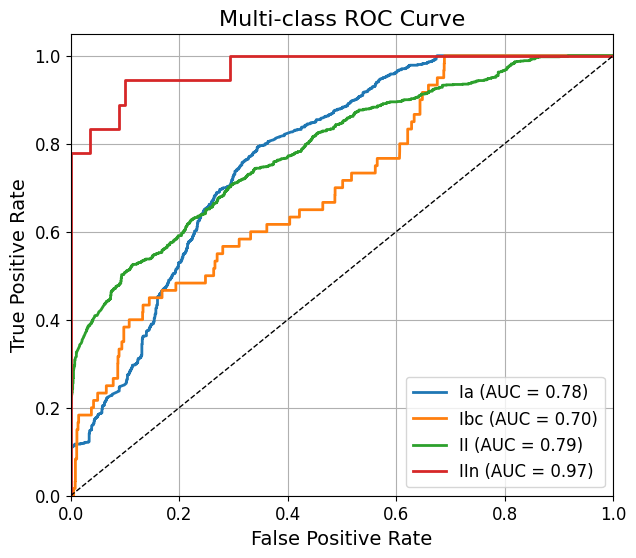

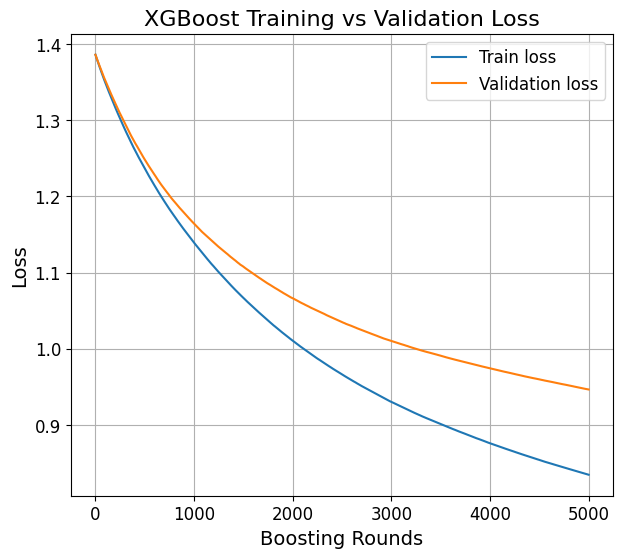


 Per-band evaluation:

--- Band = G ---
Count: 250
Accuracy: 0.676
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       161
           1       0.00      0.00      0.00        12
           2       0.08      0.02      0.03        63
           3       0.29      1.00      0.45        14

    accuracy                           0.68       250
   macro avg       0.30      0.49      0.34       250
weighted avg       0.56      0.68      0.60       250

Confusion matrix:
 [[154   1   0   6]
 [  0   0  12   0]
 [ 34   0   1  28]
 [  0   0   0  14]]

--- Band = g' ---
Count: 418
Accuracy: 0.6483253588516746
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       192
           1       0.06      0.50      0.10         8
           2       0.88      0.59      0.71       218
           3       0.00      0.00      0.00         0

    accuracy                           0.65       418
   macro avg    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [24]:
# Model 1 without downsampling
I_bdt = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=2,
    min_child_weight=5,
    subsample=0.6,
    reg_lambda=5,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt.fit(I_X_train, I_y_train,
          sample_weight=I_sample_weights,
          eval_set=[(I_X_train, I_y_train),(I_X_val, I_y_val)],
          verbose=False)
evaluate_model(I_bdt, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels)

Training set:
Accuracy: 0.6567164179104478

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68       700
           1       0.66      0.44      0.53       417
           2       0.70      0.65      0.68       700
           3       0.99      0.64      0.78       126

    accuracy                           0.66      1943
   macro avg       0.74      0.63      0.67      1943
weighted avg       0.67      0.66      0.65      1943


Confusion matrix:
 [[553  22 125   0]
 [173 184  60   0]
 [180  61 458   1]
 [ 18  13  14  81]]

Test set:

Not classified: 0
Accuracy: 0.4712230215827338

Classification report:
               precision    recall  f1-score   support

           0       0.41      0.60      0.49       100
           1       0.34      0.42      0.37        60
           2       0.72      0.33      0.45       100
           3       1.00      0.72      0.84        18

    accuracy                           0.47 

/tmp/ipython-input-3375704078.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


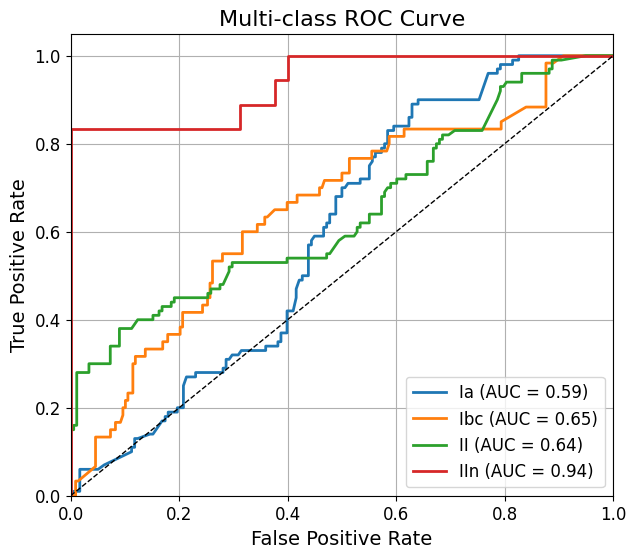

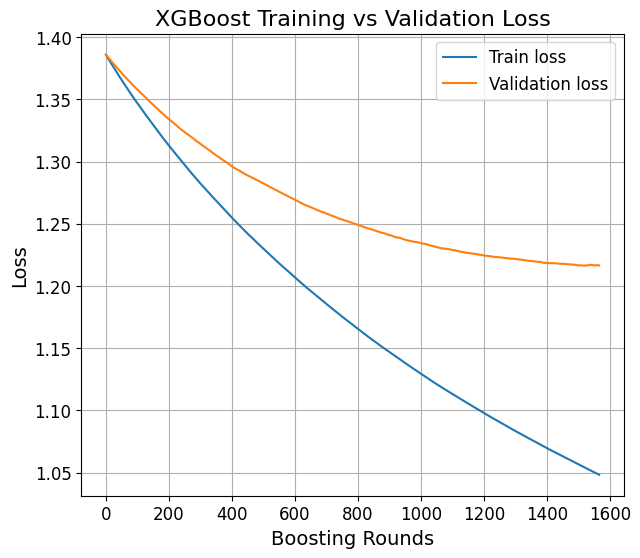


 Per-band evaluation:

--- Band = G ---
Count: 39
Accuracy: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.30      0.78      0.44         9
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00        13

    accuracy                           0.54        39
   macro avg       0.41      0.47      0.40        39
weighted avg       0.50      0.54      0.47        39

Confusion matrix:
 [[ 1 10  0  0]
 [ 2  7  0  0]
 [ 0  6  0  0]
 [ 0  0  0 13]]

--- Band = g' ---
Count: 46
Accuracy: 0.43478260869565216
              precision    recall  f1-score   support

           0       0.39      0.73      0.51        15
           1       0.22      0.29      0.25         7
           2       0.78      0.29      0.42        24

    accuracy                           0.43        46
   macro avg       0.46      0.44      0.40        46
weighted avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [25]:
# Model 1 with downsampling
I_bdt_down = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=2,
    subsample=0.6,
    # colsample_bytree=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt_down.fit(I_X_train_down, I_y_train_down,
               sample_weight=I_sample_weights_down,
               eval_set=[(I_X_train_down, I_y_train_down),(I_X_test_down, I_y_test_down)],
               verbose=False)
evaluate_model(I_bdt_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels)

## Model 2

Training set:
Accuracy: 0.7699514991181657

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.60      0.74      8846
           1       0.26      0.63      0.37       423
           2       0.72      0.95      0.82      8736
           3       0.79      0.74      0.76       139

    accuracy                           0.77     18144
   macro avg       0.69      0.73      0.67     18144
weighted avg       0.84      0.77      0.77     18144


Confusion matrix:
 [[5283  398 3146   19]
 [  17  266  140    0]
 [  54  355 8318    9]
 [   0   12   24  103]]

Test set:

Not classified: 3
Accuracy: 0.6799227799227799

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.48      0.64      1261
           1       0.16      0.38      0.22        60
           2       0.63      0.90      0.74      1249
           3       0.47      0.80      0.59        20

    accuracy                

/tmp/ipython-input-3375704078.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


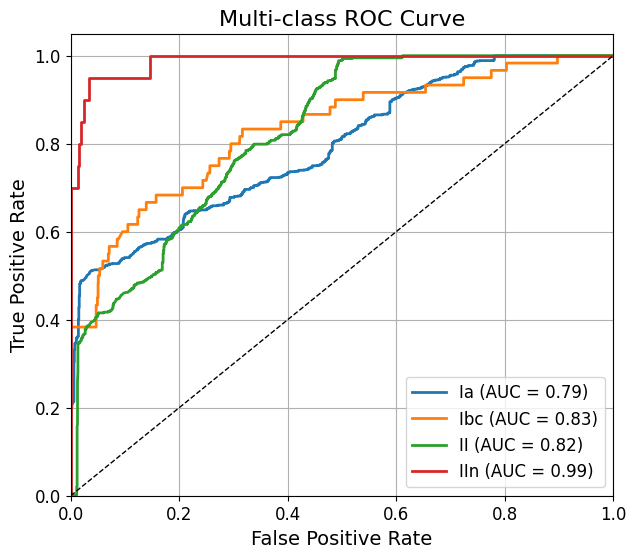

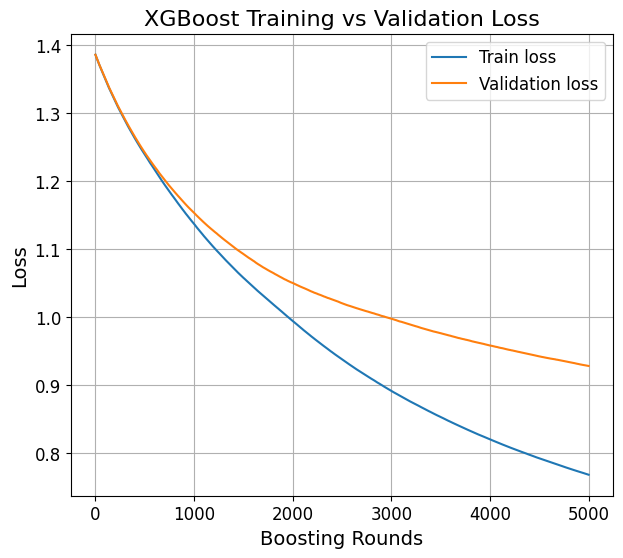


 Per-band evaluation:

--- Band = G ---
Count: 248
Accuracy: 0.9919354838709677
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       157
           1       1.00      1.00      1.00        13
           2       1.00      0.97      0.98        65
           3       1.00      1.00      1.00        13

    accuracy                           0.99       248
   macro avg       1.00      0.99      0.99       248
weighted avg       0.99      0.99      0.99       248

Confusion matrix:
 [[157   0   0   0]
 [  0  13   0   0]
 [  2   0  63   0]
 [  0   0   0  13]]

--- Band = g' ---
Count: 477
Accuracy: 0.6624737945492662
              precision    recall  f1-score   support

           0       0.94      0.44      0.60       232
           1       0.11      0.38      0.17         8
           2       0.62      0.89      0.73       236
           3       1.00      1.00      1.00         1

    accuracy                           0.66       477
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Model 2 without downsampling
II_bdt = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=2,
    min_child_weight=3,
    subsample=0.7,
    # colsample_bytree=0.7,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt.fit(II_X_train, II_y_train,
          sample_weight=II_sample_weights,
          eval_set=[(II_X_train, II_y_train),(II_X_val, II_y_val)],
          verbose=False)

evaluate_model(II_bdt, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test, II_labels)

Training set:
Accuracy: 0.9158721256309591

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.56      0.71      1400
           1       0.79      0.48      0.59       423
           2       0.91      1.00      0.95      8736
           3       1.00      0.68      0.81       139

    accuracy                           0.92     10698
   macro avg       0.92      0.68      0.77     10698
weighted avg       0.92      0.92      0.91     10698


Confusion matrix:
 [[ 787   42  571    0]
 [  15  202  206    0]
 [  12    9 8715    0]
 [   0    4   41   94]]

Test set:

Not classified: 0
Accuracy: 0.7697841726618705

Classification report:
               precision    recall  f1-score   support

           0       0.32      0.49      0.39       200
           1       0.66      0.32      0.43        60
           2       0.89      0.84      0.87      1249
           3       0.77      0.50      0.61        20

    accuracy                

/tmp/ipython-input-3375704078.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


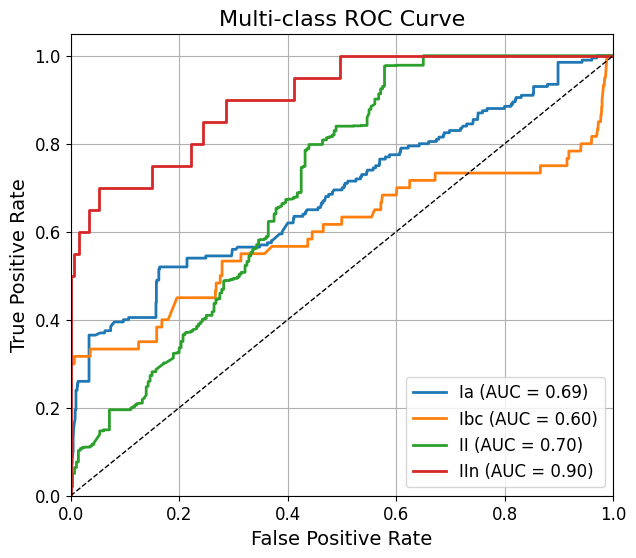

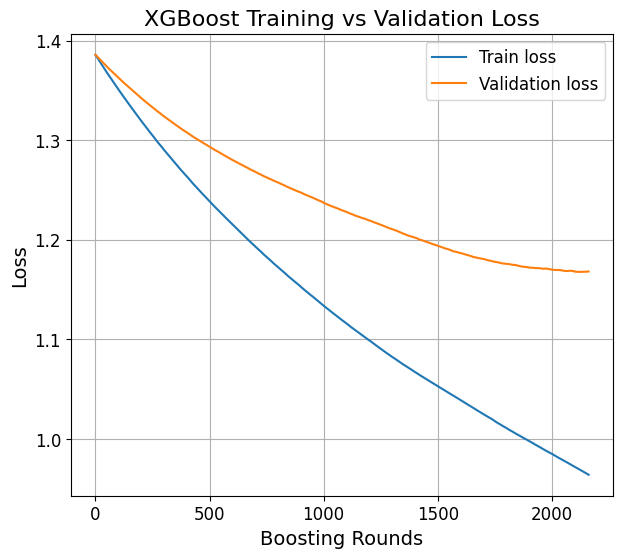


 Per-band evaluation:

--- Band = G ---
Count: 120
Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        24
           1       0.61      0.85      0.71        13
           2       1.00      0.88      0.94        74
           3       1.00      1.00      1.00         9

    accuracy                           0.87       120
   macro avg       0.82      0.88      0.84       120
weighted avg       0.89      0.87      0.87       120

Confusion matrix:
 [[19  5  0  0]
 [ 2 11  0  0]
 [ 7  2 65  0]
 [ 0  0  0  9]]

--- Band = g' ---
Count: 294
Accuracy: 0.673469387755102
              precision    recall  f1-score   support

           0       0.18      0.38      0.25        39
           1       0.25      0.20      0.22         5
           2       0.88      0.73      0.80       250

    accuracy                           0.67       294
   macro avg       0.44      0.44      0.42       294
weighted avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [36]:
# Model 2 with downsampling
II_bdt_down = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=2,
    min_child_weight=3,
    subsample=0.6,
    # colsample_bytree=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt_down.fit(II_X_train_down, II_y_train_down,
                sample_weight=II_sample_weights_down,
                eval_set=[(II_X_train_down, II_y_train_down),(II_X_val_down, II_y_val_down)],
                verbose=False)
evaluate_model(II_bdt_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Though downsampling seems to make it worse for the classifier, the effect is not as strong as the other two classifiers.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers.
- Model 2 outperforms Model 1. Probably because it has more features.
- Boosted decision tree classifier is the most effective, which agrees with the paper.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
- In Model 2, we did a better job than the paper. Yay 😎!